In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
df_bureau = pd.read_csv('input/bureau.csv')
df_bureau.info()
print('----------')
df_app = pd.read_csv('input/application_train.csv',index_col='SK_ID_CURR')
df_app.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
SK_ID_CURR                int64
SK_ID_BUREAU              int64
CREDIT_ACTIVE             object
CREDIT_CURRENCY           object
DAYS_CREDIT               int64
CREDIT_DAY_OVERDUE        int64
DAYS_CREDIT_ENDDATE       float64
DAYS_ENDDATE_FACT         float64
AMT_CREDIT_MAX_OVERDUE    float64
CNT_CREDIT_PROLONG        int64
AMT_CREDIT_SUM            float64
AMT_CREDIT_SUM_DEBT       float64
AMT_CREDIT_SUM_LIMIT      float64
AMT_CREDIT_SUM_OVERDUE    float64
CREDIT_TYPE               object
DAYS_CREDIT_UPDATE        int64
AMT_ANNUITY               float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB
----------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 100002 to 456255
Columns: 121 entries, TARGET to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 286.2+ MB


In [47]:
df_bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


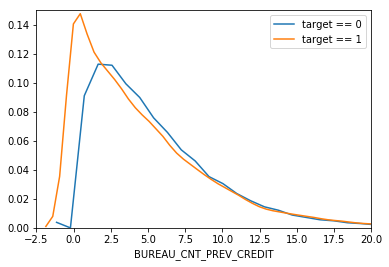

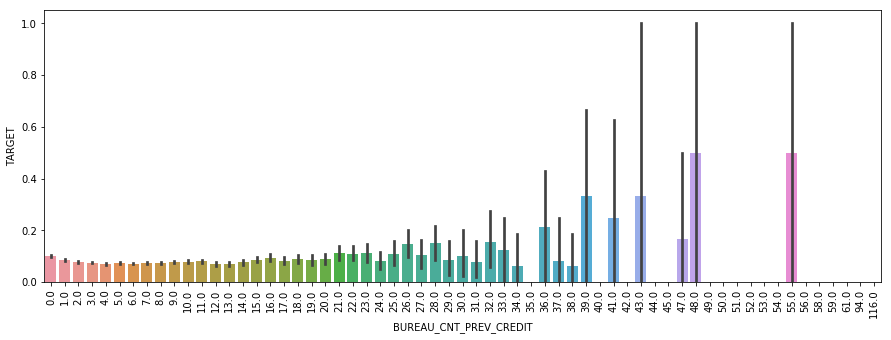

In [78]:
df_app['BUREAU_CNT_PREV_CREDIT'] = df_bureau.SK_ID_CURR.value_counts()
df_app['BUREAU_CNT_PREV_CREDIT'].fillna(0,inplace=True)

sns.kdeplot(df_app.loc[df_app['TARGET'] == 0, 'BUREAU_CNT_PREV_CREDIT'].dropna(), label='target == 0')
sns.kdeplot(df_app.loc[df_app['TARGET'] == 1, 'BUREAU_CNT_PREV_CREDIT'].dropna(), label='target == 1')
plt.xlim([-2.5,20])
plt.ylim([0,0.15])
plt.xlabel('BUREAU_CNT_PREV_CREDIT')
# people without previous credit more likely to default?

plt.figure(figsize=(15,5))
sns.barplot(x='BUREAU_CNT_PREV_CREDIT',y='TARGET',data=df_app)
plt.xticks(rotation=90);

In [59]:
cnt_credit = df_bureau.groupby('SK_ID_CURR').CREDIT_ACTIVE.value_counts().unstack(fill_value=0)
cnt_credit.columns = 'BUREAU_CNT_CREDIT_'+cnt_credit.columns.values

df_app = df_app.merge(cnt_credit,how='left',left_index=True,right_index=True)

for col in cnt_credit.columns:
    plt.figure()
    sns.barplot(x=col,y='TARGET',data=df_app)
    plt.xticks(rotation=90)

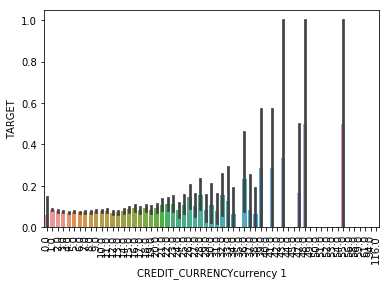

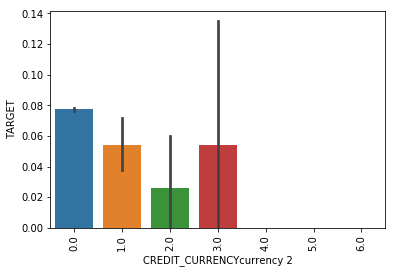

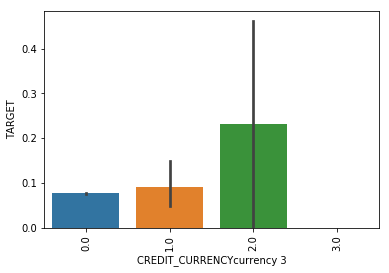

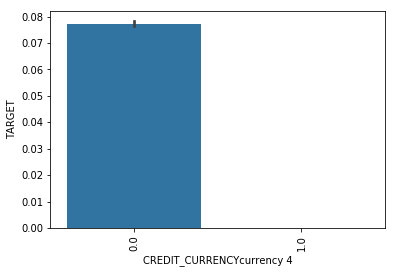

In [80]:
cnt_curr = df_bureau.groupby('SK_ID_CURR').CREDIT_CURRENCY.value_counts().unstack(fill_value=0)
cnt_curr.columns = 'BUREAU_CNT_'+cnt_curr.columns.values

df_app = df_app.merge(cnt_curr,how='left',left_index=True,right_index=True)

for col in cnt_curr.columns:
    plt.figure()
    sns.barplot(x=col,y='TARGET',data=df_app)
    plt.xticks(rotation=90)

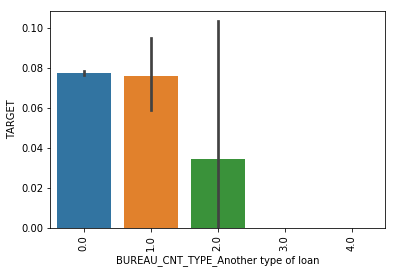

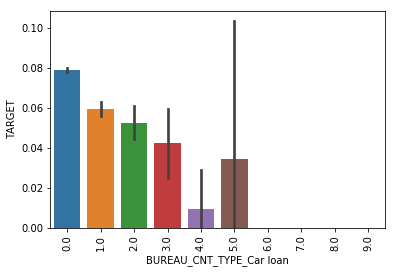

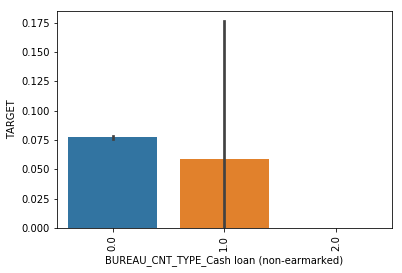

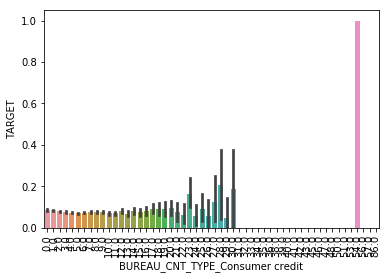

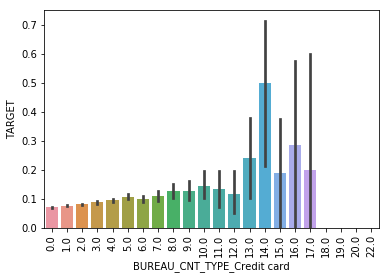

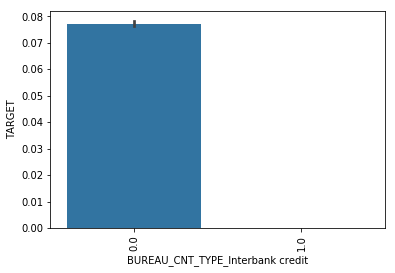

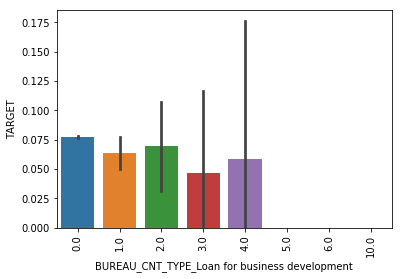

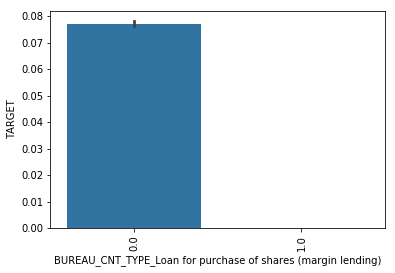

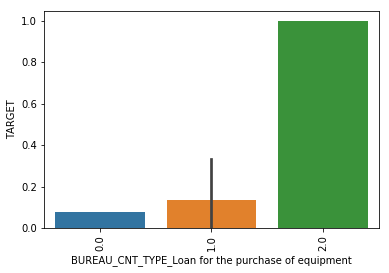

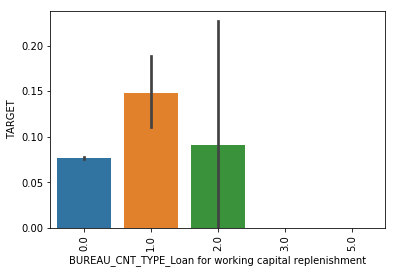

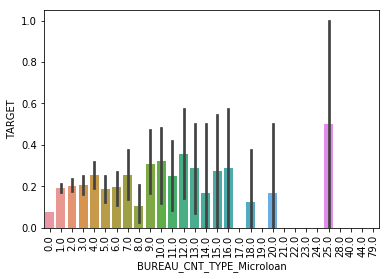

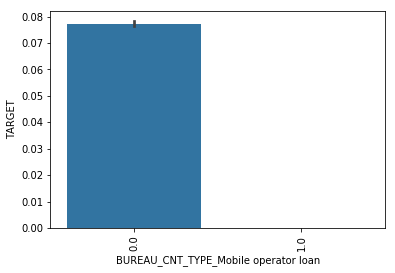

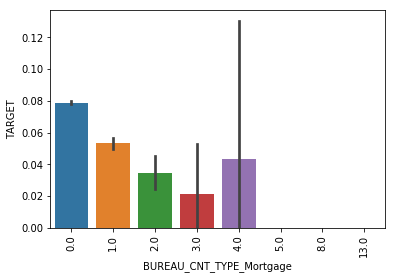

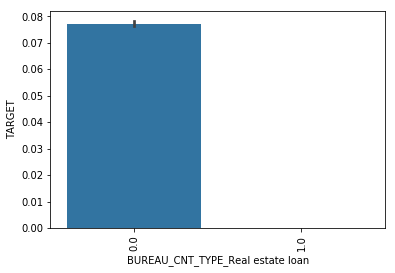

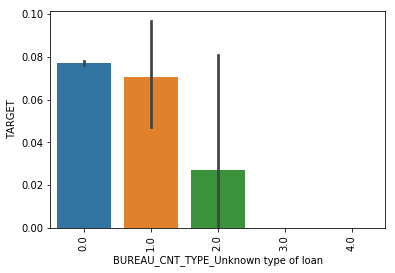

In [86]:
df_bureau['CREDIT_TYPE'].value_counts()

cnt_typ = df_bureau.groupby('SK_ID_CURR').CREDIT_TYPE.value_counts().unstack(fill_value=0)
cnt_typ.columns = 'BUREAU_CNT_TYPE_'+cnt_typ.columns.values

df_app = df_app.merge(cnt_typ,how='left',left_index=True,right_index=True)

for col in cnt_typ.columns:
    plt.figure()
    sns.barplot(x=col,y='TARGET',data=df_app)
    plt.xticks(rotation=90)

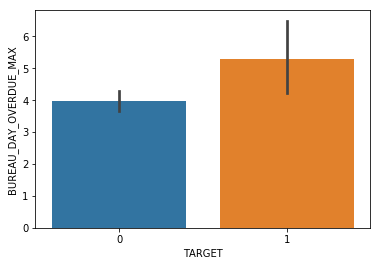

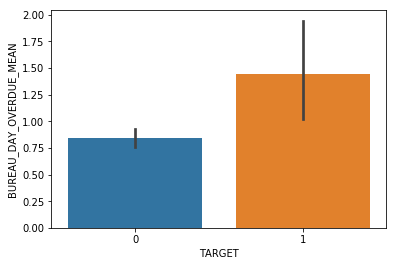

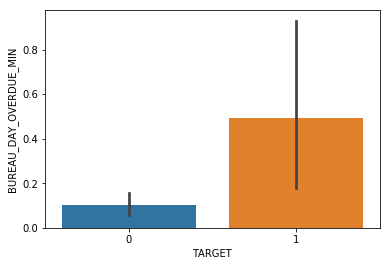

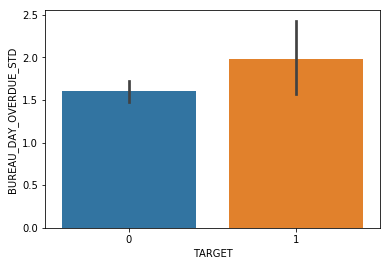

In [107]:
df_app['BUREAU_DAY_OVERDUE_MAX'] = df_bureau.groupby('SK_ID_CURR').CREDIT_DAY_OVERDUE.max()
df_app['BUREAU_DAY_OVERDUE_MAX'].fillna(0,inplace=True)
sns.barplot(x='TARGET',y='BUREAU_DAY_OVERDUE_MAX',data=df_app)

df_app['BUREAU_DAY_OVERDUE_MEAN'] = df_bureau.groupby('SK_ID_CURR').CREDIT_DAY_OVERDUE.mean()
df_app['BUREAU_DAY_OVERDUE_MEAN'].fillna(0,inplace=True)
plt.figure()
sns.barplot(x='TARGET',y='BUREAU_DAY_OVERDUE_MEAN',data=df_app)

df_app['BUREAU_DAY_OVERDUE_MIN'] = df_bureau.groupby('SK_ID_CURR').CREDIT_DAY_OVERDUE.min()
df_app['BUREAU_DAY_OVERDUE_MIN'].fillna(0,inplace=True)
plt.figure()
sns.barplot(x='TARGET',y='BUREAU_DAY_OVERDUE_MIN',data=df_app)

df_app['BUREAU_DAY_OVERDUE_STD'] = df_bureau.groupby('SK_ID_CURR').CREDIT_DAY_OVERDUE.std()
df_app['BUREAU_DAY_OVERDUE_STD'].fillna(0,inplace=True)
plt.figure()
sns.barplot(x='TARGET',y='BUREAU_DAY_OVERDUE_STD',data=df_app)

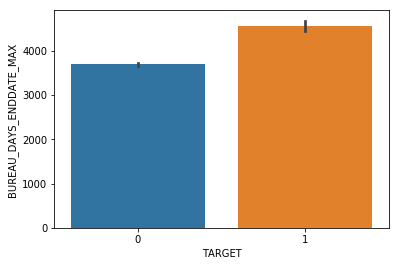

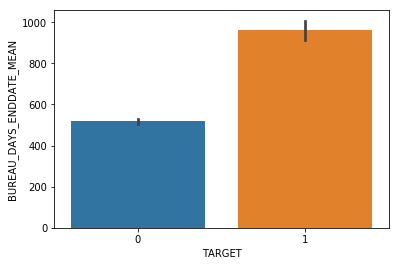

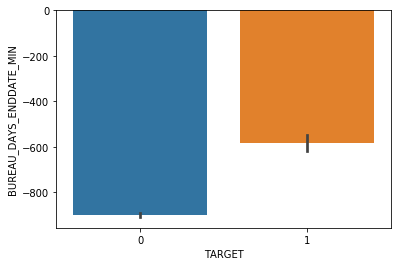

In [104]:
df_app['BUREAU_DAYS_ENDDATE_MAX'] = df_bureau.groupby('SK_ID_CURR').DAYS_CREDIT_ENDDATE.max()
df_app['BUREAU_DAYS_ENDDATE_MAX'].fillna(0,inplace=True)
plt.figure()
sns.barplot(x='TARGET',y='BUREAU_DAYS_ENDDATE_MAX',data=df_app)

df_app['BUREAU_DAYS_ENDDATE_MEAN'] = df_bureau.groupby('SK_ID_CURR').DAYS_CREDIT_ENDDATE.mean()
df_app['BUREAU_DAYS_ENDDATE_MEAN'].fillna(0,inplace=True)
plt.figure()
sns.barplot(x='TARGET',y='BUREAU_DAYS_ENDDATE_MEAN',data=df_app)

df_app['BUREAU_DAYS_ENDDATE_MIN'] = df_bureau.groupby('SK_ID_CURR').DAYS_CREDIT_ENDDATE.min()
df_app['BUREAU_DAYS_ENDDATE_MIN'].fillna(0,inplace=True)
plt.figure()
sns.barplot(x='TARGET',y='BUREAU_DAYS_ENDDATE_MIN',data=df_app)
